In [4]:
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import surprise as sp
import time

In [5]:
UsersDF = pd.read_csv('dataset/users_cleaned.csv')
AnimesDF = pd.read_csv('dataset/anime_cleaned.csv')
ScoresDF = pd.read_csv('dataset/animelists_cleaned.csv')

In [103]:
print(AnimesDF.info())
AnimesDF.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6668 entries, 0 to 6667
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6668 non-null   int64  
 1   title            6668 non-null   object 
 2   title_english    3438 non-null   object 
 3   title_japanese   6663 non-null   object 
 4   title_synonyms   4481 non-null   object 
 5   image_url        6666 non-null   object 
 6   type             6668 non-null   object 
 7   source           6668 non-null   object 
 8   episodes         6668 non-null   int64  
 9   status           6668 non-null   object 
 10  airing           6668 non-null   bool   
 11  aired_string     6668 non-null   object 
 12  aired            6668 non-null   object 
 13  duration         6668 non-null   object 
 14  rating           6668 non-null   object 
 15  score            6668 non-null   float64
 16  scored_by        6668 non-null   int64  
 17  rank          

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [104]:
print(UsersDF.info())
UsersDF.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108711 entries, 0 to 108710
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   username                  108710 non-null  object 
 1   user_id                   108711 non-null  int64  
 2   user_watching             108711 non-null  int64  
 3   user_completed            108711 non-null  int64  
 4   user_onhold               108711 non-null  int64  
 5   user_dropped              108711 non-null  int64  
 6   user_plantowatch          108711 non-null  int64  
 7   user_days_spent_watching  108711 non-null  float64
 8   gender                    108711 non-null  object 
 9   location                  108706 non-null  object 
 10  birth_date                108711 non-null  object 
 11  access_rank               0 non-null       float64
 12  join_date                 108711 non-null  object 
 13  last_online               108711 non-null  o

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


In [105]:
print(ScoresDF.info())
ScoresDF.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31284030 entries, 0 to 31284029
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   username   object
 1   anime_id   int64 
 2   my_score   int64 
 3   my_status  int64 
dtypes: int64(3), object(1)
memory usage: 954.7+ MB
None


,username,anime_id,my_score,my_status
0,karthiga,21,9,1
1,karthiga,59,7,2
2,karthiga,74,7,2
3,karthiga,120,7,2
4,karthiga,178,7,2


Убираем из таблицы ScoresDF ненужные столбцы

In [9]:
ScoresDF = ScoresDF[['username', 'anime_id', 'my_score', 'my_status']]

Проверяем диапазон доступных рейтинговых оценок

In [10]:
lower_rating = ScoresDF['my_score'].min()
upper_rating = ScoresDF['my_score'].max()
print('Диапазон оценок: {0} до {1}'.format(lower_rating, upper_rating))

Диапазон оценок: 0 до 10


Считаем, сколько раз каждый пользователь оценил какой-либо тайтл, т.е. сколько оценок он поставил за всё время

In [11]:
UsersAndScores = ScoresDF['username'].value_counts().reset_index().rename(columns={"username": "animes_rated", "index": "username"})
UsersAndScores.head(10)

,username,animes_rated
0,Exxorn,6536
1,uemmega,6367
2,JakCooper2,5923
3,DeadlyKizuna,5912
4,KanaenuYume,5234
5,NightTerror,5151
6,DesireDestiny,5062
7,Cafer,4777
8,Dragonflyk,4632
9,Virali,4524


In [12]:
UsersSampled = UsersDF.sample(frac = .01, random_state = 2)
UsersSampled.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
48731,Saperella,98375,21,162,0,4,28,34.550000,Male,"York, UK",1989-08-31 00:00:00,NaN,2008-09-25 00:00:00,2010-07-22 05:41:00,7.94,4.0,2131
35191,Inugirlz,207889,52,908,227,164,300,301.467361,Female,Where Maple Leaves Reside,1994-04-04 00:00:00,NaN,2009-07-14 00:00:00,2018-05-19 14:23:41,7.16,58.0,18796
77699,Luu-Senpai,5393511,10,663,0,0,19,177.401111,Male,Buenos Aires,1991-05-23 00:00:00,NaN,2016-05-07 00:00:00,2018-04-27 04:38:21,7.72,0.0,11129
95207,OzzyOtaku,607875,16,342,0,76,69,91.565278,Male,TEXAS,1989-01-24 00:00:00,NaN,2011-09-19 00:00:00,2018-05-20 18:51:57,7.77,18.0,5987
85049,Ahlala,485718,1,67,29,8,32,37.024306,Female,Philippines,1991-04-10 00:00:00,NaN,2011-05-12 00:00:00,2017-07-27 01:10:00,8.31,27.0,2251


In [13]:
UsersAndScoresSampled = pd.merge(UsersAndScores, UsersSampled, left_on = 'username', right_on = 'username', how = 'inner')
UsersAndScoresSampled.head()

,username,animes_rated,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,Darkvoid,3976,280949,231,2404,133,12,3216,314.544884,Male,Germany,1980-10-05 00:00:00,NaN,2010-01-10 00:00:00,2018-05-11 19:50:31,7.80,0.0,20038
1,Red_Ranger_Wien,2881,615007,26,1361,10,0,2468,239.585671,Male,"Starkville, Mississippi",1993-07-24 00:00:00,NaN,2011-09-20 00:00:00,2018-05-15 02:58:34,6.74,0.0,16678
2,werewolfgirl1995,2591,212929,41,31,213,0,2790,13.791667,Female,"Pittsburgh,Pensylvania",1995-03-02 00:00:00,NaN,2009-07-25 00:00:00,2018-04-24 07:55:06,9.05,0.0,825
3,gust11,2200,1605329,174,958,5,0,1256,206.283912,Male,The Hyperdimension,2000-01-19 00:00:00,NaN,2012-10-08 00:00:00,2017-12-24 02:52:46,8.24,39.0,13163
4,RyokoAyekaLover,2106,81624,359,573,1,0,1763,242.313565,Male,"United States,New York",1991-06-11 00:00:00,NaN,2008-07-31 00:00:00,2018-05-20 03:12:24,0.00,21.0,15740


Группировка пользователей с одинаковым числом выставленных рейтингов

In [14]:
UserRatedsAggregated = UsersAndScoresSampled['animes_rated'].value_counts().reset_index().rename(columns={"animes_rated": "group_size", "index": "animes_rated"}).sort_values(by=['animes_rated']).reset_index(drop=True)
UserRatedsAggregated.head()

,animes_rated,group_size
0,1,2
1,2,4
2,3,7
3,4,3
4,5,6


Подсчет кол-ва оценок для каждого аниме

In [15]:
RatedsPerAnime = ScoresDF['anime_id'].value_counts().reset_index().rename(columns={"anime_id": "number_of_users", "index": "anime_id"})
RatedsPerAnime.head()

,anime_id,number_of_users
0,1535,81332
1,1575,67721
2,226,64486
3,5114,63649
4,4224,63278


Группировка аниме, которые оценило одинаковое количество пользователей

In [16]:
AnimeRatedsAggregated = RatedsPerAnime['number_of_users'].value_counts().reset_index().rename(columns={"number_of_users": "group_size", "index": "number_of_users"}).sort_values(by=['number_of_users'])
AnimeRatedsAggregated.head(n = 30)

,number_of_users,group_size
331,1,3
27,2,11
25,3,11
23,4,12
6,5,16
18,6,13
14,7,14
7,8,16
0,9,22
2,10,21


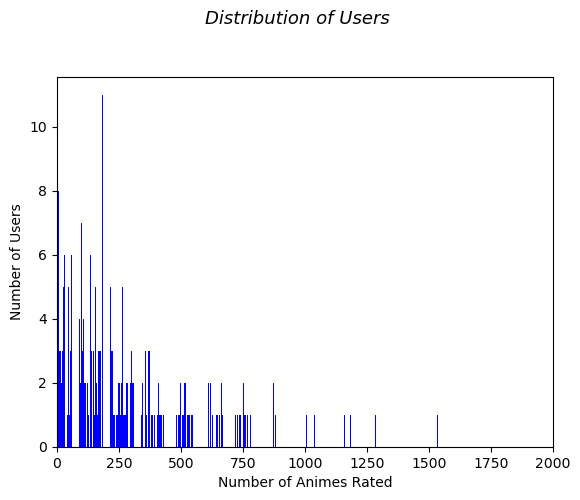

In [17]:
plt.bar(UserRatedsAggregated['animes_rated'], UserRatedsAggregated['group_size'], color='blue')

plt.suptitle("Distribution of Users", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.xlabel('Number of Animes Rated')
plt.ylabel('Number of Users')

plt.xlim(left=0, right=2000)

plt.show()

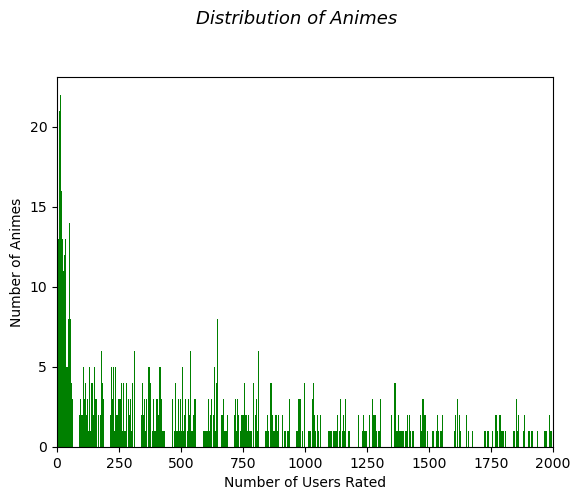

In [18]:
plt.bar(AnimeRatedsAggregated['number_of_users'], AnimeRatedsAggregated['group_size'], color='green')

plt.suptitle("Distribution of Animes", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.xlabel('Number of Users Rated')
plt.ylabel('Number of Animes')

plt.xlim(left=0, right=2000)

plt.show()

Чтобы разобраться с потенциальной проблемой *Cold-start*, просто избавимся от всех пользователей с недостаточным послужным списком.
Аналогично поступим с тайтлами, у которых недостаточно зрительских оценок.

In [19]:
UserRatedsCutten = UsersAndScoresSampled[UsersAndScoresSampled['animes_rated'] >= 10]
AnimeRatedsCutten = RatedsPerAnime[RatedsPerAnime['number_of_users'] >= 10]

ScoresDFHotStart = pd.merge(ScoresDF, UserRatedsCutten, left_on = 'username', right_on = 'username', how = 'inner')
ScoresDFHotStart = pd.merge(ScoresDFHotStart, AnimeRatedsCutten, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')
ScoresDFHotStart.head()

,username,anime_id,my_score,my_status,animes_rated,user_id,user_watching,user_completed,user_onhold,user_dropped,...,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,number_of_users
0,Tomoki-sama,21,9,3,515,1933206,10,348,15,28,...,Male,"SC, Brasil",1996-06-01 00:00:00,NaN,2012-12-22 00:00:00,2018-05-10 20:28:44,8.48,8.0,6175,45118
1,brunomp,21,0,1,138,4437072,2,133,0,0,...,Male,"Pernambuco, Brasil",1996-09-29 00:00:00,NaN,2015-01-21 00:00:00,2018-05-16 20:48:09,8.42,0.0,4060,45118
2,Mukkashi,21,8,4,521,1425283,13,327,26,23,...,Male,Saudi Arabia,1996-07-17 00:00:00,NaN,2012-07-29 00:00:00,2018-05-18 01:28:51,7.43,0.0,7030,45118
3,SocialAwkward,21,10,1,313,441230,2,214,6,9,...,Female,Somewhere over the Rainbow,2000-01-24 00:00:00,NaN,2011-01-28 00:00:00,2017-10-23 10:04:52,8.65,25.0,4692,45118
4,crazybela,21,10,1,232,217138,72,86,35,0,...,Female,Brazil,1989-10-05 00:00:00,NaN,2009-08-06 00:00:00,2014-09-25 14:45:00,7.63,0.0,2656,45118


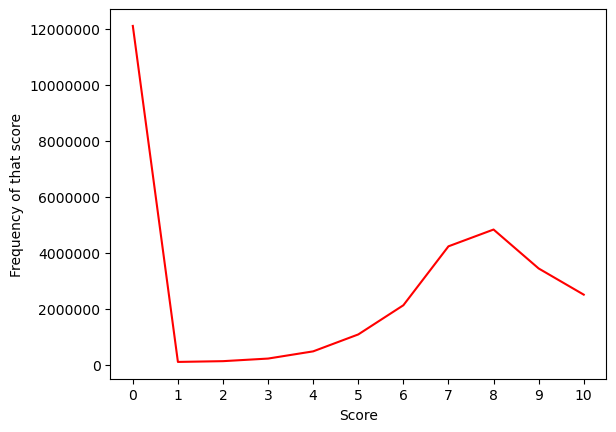

In [20]:
AnimeRates = ScoresDF['my_score'].value_counts().reset_index().sort_values('index')
plt.plot('index', 'my_score', data = AnimeRates, color = 'red')
plt.xticks(np.arange(11))
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.xlabel('Score')
plt.ylabel('Frequency of that score')
plt.show()

In [21]:
print('Размер изначального датафрейма составлял {0} записей. Размер нового составляет {1} строк.'.format(ScoresDF['username'].count(), ScoresDFHotStart['username'].count()))

Размер изначального датафрейма составлял 31283787 записей. Размер нового составляет 324206 строк.


# Метрики

In [22]:
def precision_recall_at_k(predictions, k=10, threshold=7):

    # Отображаем все предикты на соответствующих юзеров
    # Predictions: взвращает список внутри кортежа с 5 полями: User_ID, Item_ID, True_ID, Est_ID, Details
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    # Создаем словарь, где глючем будет имя юзера, а значениями - предрлагаемая оценка и реальная
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # сортируем оценки юзеров по их предролагаемым оценкам
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Количество потенциально интересных тайтлов для юзера
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Кол-во порекомендованных тайтлов из топа k оценок
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Кол-во тайтлов, являющихся потенциально интересными, которые порекомендовали
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: доля порекомендованных и потенциально интересных тайтлов ко всем порекомендованным
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: доля порекомендованных и потенциально интересных тайтлов ко всем потенциально интересным
        recalls[uid] = n_rel_and_rec_k /  n_rel if n_rel != 0 else 1

    return precisions, recalls

# model-based filtering

In [23]:
random_state = 55
reader = sp.Reader(rating_scale=(0, 10))
data = sp.Dataset.load_from_df(ScoresDFHotStart[['username', 'anime_id', 'my_score']], reader)
trainset, testset = sp.model_selection.train_test_split(data, test_size=.25, random_state = random_state)
analysis = defaultdict(list)

test_dict = {'SVD' : sp.SVD(random_state=random_state), 'SlopeOne' : sp.SlopeOne(), 'NMF' : sp.NMF(random_state=random_state), 'NormalPredictor' : sp.NormalPredictor(), 'KNNBaseline' : sp.KNNBaseline(random_state=random_state), 'KNNBasic' : sp.KNNBasic(random_state=random_state), 'KNNWithMeans' : sp.KNNWithMeans(random_state=random_state), 'KNNWithZScore' : sp.KNNWithZScore(random_state=random_state), 'BaselineOnly' : sp.BaselineOnly(), 'CoClustering': sp.CoClustering(random_state=random_state)}

for key, value in test_dict.items():
    start = time.time()    
    value.fit(trainset)
    predictions = value.test(testset)

    rmse = sp.accuracy.rmse(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold= 7)
    precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
    recall_avg = sum(rec for rec in recalls.values()) / len(recalls)

    analysis[value] = (key, rmse, precision_avg, recall_avg, time.time() - start)

print(analysis)

RMSE: 3.5273
RMSE: 3.2536
RMSE: 3.3827
RMSE: 5.1338
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2133
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.3713
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2402
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2435
Estimating biases using als...
RMSE: 3.2438
RMSE: 3.3002
defaultdict(<class 'list'>, {<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000027C55AB9450>: ('SVD', 3.5272999103419918, 0.7679063644688627, 0.23631672518953883, 4.621271133422852), <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x0000027D0BFBD050>: ('SlopeOne', 3.2535936988117875, 0.899965659340658, 0.18205016943834892, 47.58552169799805), <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x0000027D34719CD0>: ('NMF', 3.3827020335591182, 0.8042933455433436,

In [24]:
analysis_df = pd.DataFrame.from_dict(analysis, orient = 'index', columns = ['Algorithm', 'RMSE', 'Precision@10', 'Recall', 'Time to run (in seconds)']).reset_index()

analysis_df = analysis_df[['Algorithm', 'RMSE', 'Precision@10', 'Recall', 'Time to run (in seconds)']]
analysis_df = analysis_df.sort_values(by=['Precision@10'], ascending = False)
analysis_df['RMSE^-1'] = analysis_df['RMSE'] ** -1
analysis_df.head(n = 15)

,Algorithm,RMSE,Precision@10,Recall,Time to run (in seconds),RMSE^-1
8,BaselineOnly,3.243777,0.919489,0.148350,1.057638,0.308283
4,KNNBaseline,3.213338,0.906526,0.176099,17.551008,0.311203
1,SlopeOne,3.253594,0.899966,0.182050,47.585522,0.307352
6,KNNWithMeans,3.240166,0.895986,0.193797,15.044319,0.308626
9,CoClustering,3.300234,0.873900,0.215972,8.408782,0.303009
7,KNNWithZScore,3.243515,0.864266,0.212017,15.645839,0.308307
5,KNNBasic,3.371294,0.831502,0.219416,14.450829,0.296622
2,NMF,3.382702,0.804293,0.192513,7.947807,0.295622
0,SVD,3.527300,0.767906,0.236317,4.621271,0.283503
3,NormalPredictor,5.133846,0.550054,0.196460,0.846998,0.194786


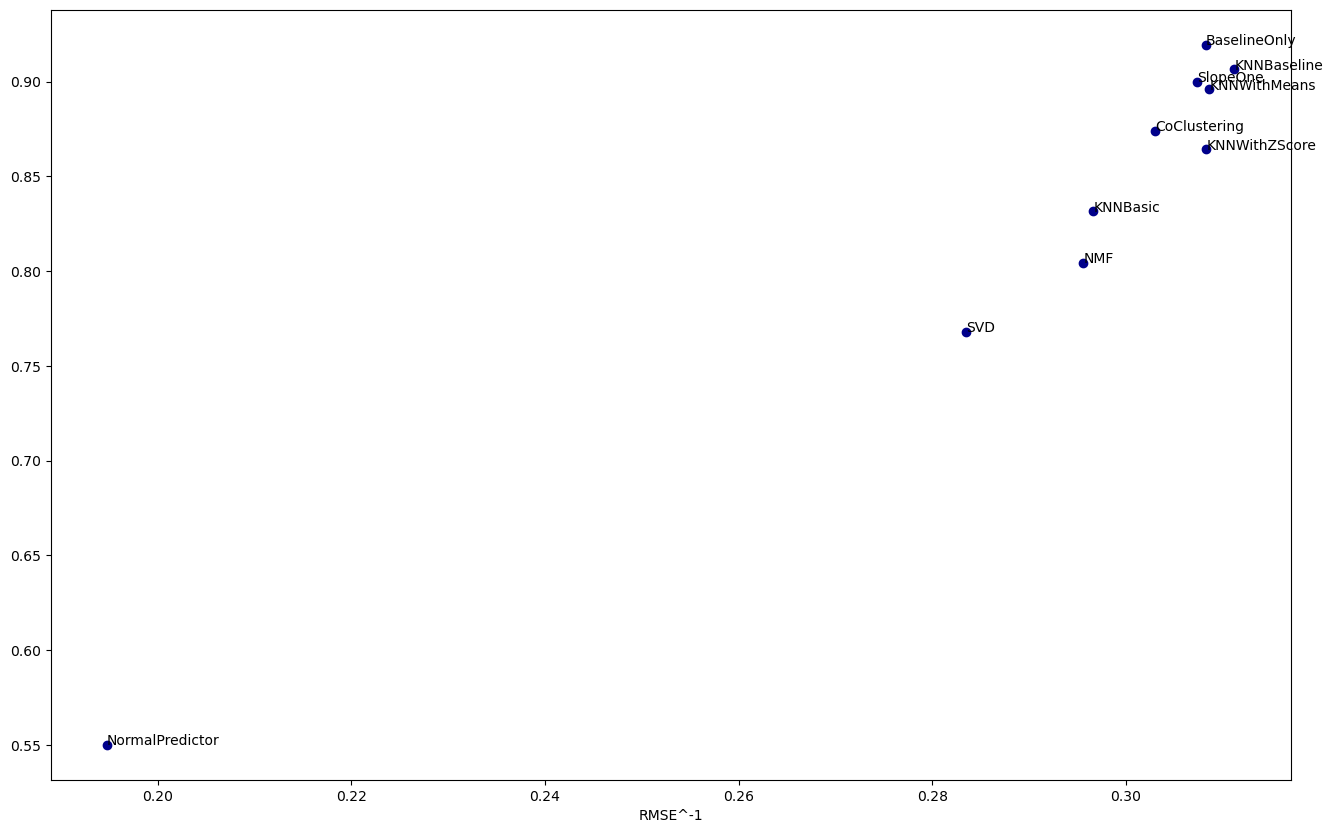

In [25]:
ax = analysis_df.set_index('RMSE^-1')['Precision@10'].plot(style='o', c = 'DarkBlue', figsize = (16, 10))
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(analysis_df['RMSE^-1'], analysis_df['Precision@10'], analysis_df['Algorithm'], ax)

In [26]:
als_param_grid = {'bsl_options': {'method': ['als'],
                              'reg_i': [5, 10, 15],
                              'reg_u': [10, 15, 20],
                              'n_epochs': [5, 10, 15, 20]
                              }
              }

sgd_param_grid = {'bsl_options': {'method': ['sgd'],
                              'reg': [0.01, 0.02, 0.03],
                              'n_epochs': [5, 10, 15, 20],
                              'learning_rate' : [0.001, 0.005, 0.01]
                              }
              }
    
als_gs = sp.model_selection.GridSearchCV(sp.BaselineOnly, als_param_grid, measures=['rmse'], cv = 3, joblib_verbose = 0)

sgd_gs = sp.model_selection.GridSearchCV(sp.BaselineOnly, sgd_param_grid, measures=['rmse'], cv = 3, joblib_verbose = 0)

In [27]:
als_gs.fit(data)
sgd_gs.fit(data)

# лучшая RMSE ALS оценка
print(als_gs.best_score['rmse'])

# комбинация параметров для RMSE ALS с наилучшей оценкой
print(als_gs.best_params['rmse'])

# лучшая RMSE SGD оценка
print(sgd_gs.best_score['rmse'])

# комбинация параметров для RMSE SGD с наилучшей оценкой
print(sgd_gs.best_params['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [28]:
# best_params = {'bsl_options': {'method': 'sgd', 'reg': 0.01, 'n_epochs': 20, 'learning_rate': 0.005}}
trainset = data.build_full_trainset()
# algo = sp.BaselineOnly(**best_params)
algo = sp.BaselineOnly()
algo.fit(trainset)
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
    
last_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
last_predictions.drop('rui', inplace = True, axis = 1)
last_predictions.head()

Estimating biases using als...


,uid,iid,est,details
0,Tomoki-sama,269,7.017301,{'was_impossible': False}
1,Tomoki-sama,1735,7.004074,{'was_impossible': False}
2,Tomoki-sama,47,7.092532,{'was_impossible': False}
3,Tomoki-sama,270,6.210099,{'was_impossible': False}
4,Tomoki-sama,442,6.543776,{'was_impossible': False}


In [29]:
def bringing_first_n_values(df, uid, n=10):
    df = df[df['uid'] == uid].nlargest(n, 'est')[['uid', 'iid', 'est']]
    df = pd.merge(df, AnimesDF, left_on = 'iid', right_on = 'anime_id', how = 'left')
    return df[['uid', 'est', 'title', 'genre']]

In [30]:
bringing_first_n_values(last_predictions, 'crazybela')

,uid,est,title,genre
0,crazybela,7.820385,Shingeki no Kyojin,"Action, Military, Mystery, Super Power, Drama,..."
1,crazybela,7.685434,Howl no Ugoku Shiro,"Adventure, Drama, Fantasy, Romance"
2,crazybela,7.599200,One Punch Man,"Action, Sci-Fi, Comedy, Parody, Super Power, S..."
3,crazybela,7.545264,Mononoke Hime,"Action, Adventure, Fantasy"
4,crazybela,7.468002,Haikyuu!! Second Season,"Comedy, Sports, Drama, School, Shounen"
5,crazybela,7.436100,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Sports, Drama, School, Shounen"
6,crazybela,7.413706,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
7,crazybela,7.378313,Kimi no Na wa.,"Supernatural, Drama, Romance, School"
8,crazybela,7.330798,Shelter,"Sci-Fi, Music"
9,crazybela,7.228083,Final Fantasy VII: Advent Children,"Action, Super Power, Fantasy"


# item-based filtering

In [31]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo_items = sp.KNNBaseline(sim_options=sim_options)
algo_items.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [32]:
def get_item_recommendations(anime_title, anime_id=100000, k=10):
    if anime_id == 100000:     
        anime_id = AnimesDF[AnimesDF['title'] == anime_title]['anime_id'].iloc[0]
        
    iid = algo_items.trainset.to_inner_iid(anime_id)
    neighbors = algo_items.get_neighbors(iid, k=k)
    raw_neighbors = (algo.trainset.to_raw_iid(inner_id) for inner_id in neighbors)
    df = pd.DataFrame(raw_neighbors, columns = ['Anime_ID'])
    df = pd.merge(df, AnimesDF, left_on = 'Anime_ID', right_on = 'anime_id', how = 'left')
    return df[['Anime_ID', 'title', 'genre']]

In [33]:
get_item_recommendations('Haikyuu!! Second Season', k=30)

,Anime_ID,title,genre
0,20583,Haikyuu!!,"Comedy, Drama, School, Shounen, Sports"
1,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Sports, Drama, School, Shounen"
2,28623,Koutetsujou no Kabaneri,"Action, Drama, Fantasy, Horror"
3,28927,Owari no Seraph: Nagoya Kessen-hen,"Action, Military, Supernatural, Drama, Vampire..."
4,23199,Durarara!!x2 Shou,"Action, Mystery, Supernatural"
5,27831,Durarara!!x2 Ten,"Action, Mystery, Supernatural"
6,32995,Yuri!!! on Ice,"Comedy, Sports"
7,24277,Yowamushi Pedal: Grande Road,"Comedy, Drama, Shounen, Sports"
8,31964,Boku no Hero Academia,"Action, Comedy, School, Shounen, Super Power"
9,16894,Kuroko no Basket 2nd Season,"Comedy, Sports, School, Shounen"


# Content-based

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

genres_str = AnimesDF['genre'].str.split(',').astype(str)

tfv_matrix = tfv.fit_transform(genres_str)
tfv_matrix.shape

(6668, 1708)

In [92]:
from sklearn.metrics.pairwise import sigmoid_kernel

sig = sigmoid_kernel(tfv_matrix, tfv_matrix)
sig

array([[0.76183993, 0.76161043, 0.76159745, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76161043, 0.76183993, 0.76160435, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159745, 0.76160435, 0.76183993, ..., 0.76159416, 0.76159416,
        0.76159416],
       ...,
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76183993, 0.76168861,
        0.76168861],
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76168861, 0.76183993,
        0.76183993],
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76168861, 0.76183993,
        0.76183993]])

In [40]:
indices = pd.Series(AnimesDF.index, index=AnimesDF['title'])

indices = indices.drop_duplicates()
indices.head()

title
Inu x Boku SS          0
Seto no Hanayome       1
Shugo Chara!! Doki     2
Princess Tutu          3
Bakuman. 3rd Season    4
dtype: int64

In [101]:
def give_rec_cbf(title, sig=sig):
    idx = indices[title]

    sig_scores = list(enumerate(sig[idx]))

    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    anime_indices = [i[0] for i in sig_scores[1:11]]

    top_anime = pd.DataFrame({
        'Anime name': AnimesDF['title'].iloc[anime_indices].values,
        'Rating': AnimesDF['score'].iloc[anime_indices].values,
        'Similarity': [i[1] for i in sig_scores[1:11]]
    })

    return top_anime

In [102]:
give_rec_cbf('Shingeki no Kyojin')

,Anime name,Rating,Similarity
0,Shingeki no Kyojin Season 2,8.47,0.761840
1,Shingeki no Kyojin OVA,7.88,0.761754
2,Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa,7.76,0.761754
3,One Piece,8.54,0.761738
4,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,7.79,0.761738
5,One Piece: Long Ring Long Land-hen,6.94,0.761738
6,One Piece: Episode of East Blue - Luffy to 4-n...,8.05,0.761738
7,Charlotte: Tsuyoimono-tachi,7.56,0.761700
8,Aquarian Age: Saga II - Don&#039;t Forget Me...,5.94,0.761695
9,Kouryuu no Mimi: Mina no Shou,5.15,0.761695
